<a href="https://colab.research.google.com/github/Klingefjord/kaggle-competitions/blob/master/dog_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import os
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
%%time
# download data - only do once!

%cd /content/gdrive/My Drive/kaggle
!ls
#!kaggle competitions download -c generative-dog-images
#!unzip all-dogs.zip
#!unzip Annotation.zip

/content/gdrive/My Drive/kaggle
all-dogs      Annotation      disc  images.zip	models
all-dogs.zip  Annotation.zip  gen   __MACOSX
CPU times: user 17.1 ms, sys: 6.07 ms, total: 23.1 ms
Wall time: 4.12 s


Models

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_vector=128, channels=3):
    super(Generator, self).__init__()

    self.input_vector = input_vector
    self.channels = channels

    def convlayer(n_input, n_output, kernel_size=4, stride=2, padding=0):
      block = [
        nn.ConvTranspose2d(n_input, n_output, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(n_output),
        nn.ReLU(inplace=False)
      ]

      return block

    self.model = nn.Sequential(
        *convlayer(n_input=self.input_vector, n_output=1024, kernel_size=4, stride=1, padding=0),
        *convlayer(n_input=1024, n_output=512, kernel_size=4, stride=2, padding=1),
        *convlayer(n_input=512, n_output=256, kernel_size=4, stride=2, padding=1),
        *convlayer(n_input=256, n_output=128, kernel_size=4, stride=2, padding=1),
        *convlayer(n_input=128, n_output=64, kernel_size=4, stride=2, padding=1),
        nn.ConvTranspose2d(64, self.channels, kernel_size=3, stride=1, padding=1),
        nn.Tanh()
    )

  def forward(self, input):
    x = input.view(-1, self.input_vector, 1, 1) # convert vector into rank 4 tensor with right amount of rows
    img = self.model(x) # feed tensor through network
    return img

class Discriminator(nn.Module):
  def __init__(self, channels=3):
    super(Discriminator, self).__init__()

    self.channels = channels

    def convlayer(n_input, n_output, kernel_size=4, stride=2, padding=0, batch_norm=False):
      block = [nn.Conv2d(n_input, n_output, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)]
      if batch_norm: block.append(nn.BatchNorm2d(n_output))
      block.append(nn.LeakyReLU(negative_slope=.2, inplace=False))
      return block

    self.model = nn.Sequential(
        *convlayer(self.channels, 32, 4, 2, 1),
        *convlayer(32, 64, 4, 2, 1),
        *convlayer(64, 128, 4, 2, 1, batch_norm=True),
        *convlayer(128, 256, 4, 2, 1, batch_norm=True),
        nn.Conv2d(256, 1, 4, 1, 0, bias=False)
    )

  def forward(self, x):
    return self.model(x).view(-1, 1)

Parameters

In [ ]:
batch_size = 32
learning_rate = 1e-3
beta1 = .5
epochs = 300

real_label = .5
fake_label = 0
n_input_vector = 128

device = torch.device("cuda")

Dataset

In [ ]:
class DogDataset(Dataset):
  def __init__(self, img_dir, transform1=None, transform2=None):
    self.img_dir = img_dir
    self.transform1 = transform1
    self.transform2 = transform2

    self.imgs = []

    for i, img_name in enumerate(os.scandir(img_dir)):
      if i % 100 == 0: print(f'Image {i} / 20000') # cant check actual length of dir, colab crashes :(
      img = Image.open(img_name.path)
      if self.transform1 is not None: img = self.transform1(img)
      self.imgs.append(img)

  def __getitem__(self, index):
    img = self.imgs[index]

    if self.transform2 is not None:
      img = self.transform2(img)

    return img

  def __len__(self):
    return len(self.imgs)

all-dogs      Annotation      disc  images.zip	models
all-dogs.zip  Annotation.zip  gen   __MACOSX


Augmentations

In [ ]:
%%time
# transforms applied once when creating dataset
transform1 = transforms.Compose([transforms.Resize(64), transforms.CenterCrop(64)])

# transforms applied randomly while training
transform2 = transforms.Compose([
  transforms.RandomHorizontalFlip(p=.5),
  transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
  transforms.RandomApply([transforms.RandomRotation(degrees=5)], p=.3),
  transforms.ToTensor(),
  transforms.Normalize((.5,.5,.5), (.5,.5,.5))
])

train_dataset = DogDataset(img_dir='./all-dogs/', transform1=transform1, transform2=transform2)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

Plotting examples

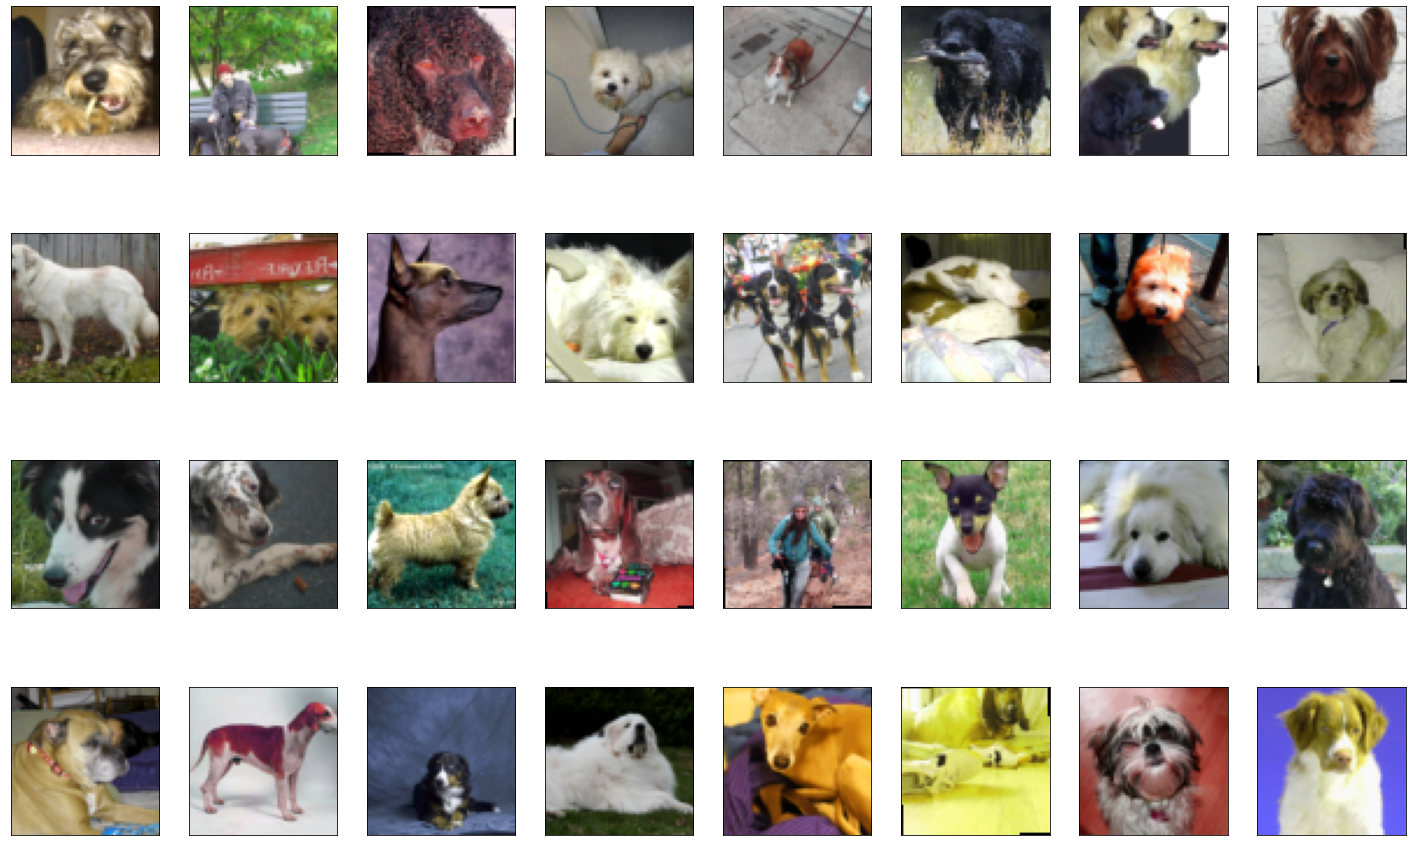

In [ ]:
fig = plt.figure(figsize=(25, 16))
for i, img in enumerate(imgs):
  ax = fig.add_subplot(4, 8, i +1, xticks=[], yticks=[])
  plt.imshow((img+1)/2)

In [ ]:
netG = Generator(n_input_vector).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

Training

In [ ]:
if not os.path.exists('./models/'):
  os.mkdir('./models/')

torch.save(netG.state_dict(), f'./models/netG_{datetime.now()}')
torch.save(netD.state_dict(), f'./models/netD_{datetime.now()}')

In [ ]:
%%time

def show_generated_img():
  noise = torch.randn(1, n_input_vector, 1, 1, device=device)
  gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
  gen_image = gen_image.numpy().transpose(1, 2, 0)
  plt.imshow((gen_image+1)/2)
  plt.show()

for epoch in range(epochs):  
    for i, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update Discriminator
        ###########################
        print("update disc s")
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        outputR = netD(real_images)
        noise = torch.randn(batch_size, n_input_vector, 1, 1, device=device)
        fake = netG(noise)
        outputF = netD(fake.detach())
        errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
                torch.mean((outputF - torch.mean(outputR) + labels) ** 2))/2
        errD.backward(retain_graph=True)
        optimizerD.step()
        print("update disc f")
        ############################
        # (2) Update Generator
        ###########################
        print("update g s")
        netG.zero_grad()
        print("update g s 2")
        with torch.autograd.set_detect_anomaly(True):
          print("update g s 3")
          outputF = netD(fake)

        print("update g s 4")
        #errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
        #        torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2

        print("update g s 5")
        with torch.autograd.set_detect_anomaly(True):
          outputF.backward()
          #errG.backward()
        print("update g s 6")
        optimizerG.step()

        print("update g f")
        
        if (i + 1) % (len(train_loader) // 2) == 0:
            print('[%d/%d][%d/%d] Loss_Disriminator: %.4f Loss_Generator: %.4f'
                  % (epoch + 1, epochs, i + 1, len(train_loader),
                     errD.item(), errG.item()))

    torch.save(netG.state_dict(), f'./models/netG_{datetime.now()}')
    torch.save(netD.state_dict(), f'./models/netD_{datetime.now()}')
    show_generated_img()

Visualise results

In [ ]:
gen_input = torch.randn(32, n_input_vector, 1, 1, device=device)
gen_images = (netG(get_input).to("cpu").clone().detach() + 1) / 2
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for i, img in enumerate(gen_images):
  ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
  plt.imshow(img)

Make predictions

In [ ]:
%%time
if not os.path.exists('./output/images'):
  os.mkdir('./output/images')
img_batch_size = 50
n_images = 1000

for i_batch in tqdm(range(0, n_images, img_batch_size)):
  gen_input = torch.randn(img_batch_size, n_input_vector, 1, 1, device=device)
  gen_images = (netG(gen_input) + 1) / 2
  images = images.numpy().transpose(0, 2, 3, 1)
  for i_img in range(gen_images.size(0)):
    save_image(gen_images[i_image, :, :, :], os.path.join('./output/images', f'image_{i_batch + i_image:05d}.png'))

import shutil
shutil.make_archive('images', 'zip', './output/images')